In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import iqr
import warnings

# Suppress harmless warnings for cleaner output
warnings.filterwarnings("ignore")

In [1]:
# --- Project Methodology ---
# This script performs an end-to-end sales forecasting analysis on an e-commerce dataset.
# The core methodology follows these steps:
# 1. Data Ingestion & Robust Preprocessing: Load the dataset, handle missing values,
#    and manage transaction types (sales vs. returns) for accurate analysis.
# 2. Time-Series Transformation: Aggregate transactional data into a monthly time series
#    to identify macro trends and prepare it for forecasting models.
# 3. Model Building & Comparison:
#    - Build an ARIMA model, a classic statistical method for time series.
#    - Build a Prophet model, a modern, business-focused forecasting tool.
# 4. Model Evaluation: Compare the performance of both models using Root Mean Squared Error (RMSE)
#    and R-squared (R2) to determine the best-performing one.
# 5. Business Forecasting: Use the superior model to forecast future monthly demand,
#    providing actionable insights for proactive supply chain optimization.

In [3]:
# Attempt to load the dataset with an appropriate encoding to handle special characters.
try:
    df = pd.read_csv('data.csv', encoding='latin1')
except FileNotFoundError:
    print("Error: The file 'data.csv' was not found. Please ensure it is in the same directory.")
    exit()
except UnicodeDecodeError:
    print("Error: Could not decode the file with 'latin1' encoding. Please check the file's encoding.")
    exit()

print(f"Initial DataFrame shape: {df.shape}")

Initial DataFrame shape: (541909, 8)


In [6]:
# Data Cleaning: Handle invalid data points and calculate sales
# Drop rows where there are missing values
df.dropna(inplace=True)
print(f"DataFrame shape after dropping missing values: {df.shape}")

# Filter out rows with negative UnitPrice. A negative price is not valid.
df = df[df['UnitPrice'] > 0]
print(f"DataFrame shape after filtering invalid prices: {df.shape}")

DataFrame shape after dropping missing values: (406789, 9)
DataFrame shape after filtering invalid prices: (406789, 9)


In [5]:
# Calculate a net sales amount. Negative quantities represent returns.
# We will use this to get a true picture of sales.
df['TotalSales'] = df['Quantity'] * df['UnitPrice']
print(f"DataFrame shape after calculating TotalSales: {df.shape}")

# Convert 'InvoiceDate' to datetime objects for time series analysis
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Aggregate daily sales for the entire store
daily_sales = df.groupby('InvoiceDate')['TotalSales'].sum().reset_index()

# Sort data by date to ensure proper time sequence
daily_sales.sort_values('InvoiceDate', inplace=True)

# Resample to monthly sales. This simplifies the time series and makes seasonality more apparent.
monthly_sales = daily_sales.set_index('InvoiceDate').resample('M')['TotalSales'].sum().reset_index()

# --- Debugging Checkpoint: Inspect the aggregated data ---
print("\n--- Aggregated Data Checkpoint ---")
print("First 5 months of aggregated sales:")
print(monthly_sales.head())
print("\nLast 5 months of aggregated sales:")
print(monthly_sales.tail())
print("\nSummary statistics of monthly sales:")
print(monthly_sales['TotalSales'].describe())
print("--- End of Aggregated Data Checkpoint ---\n")

DataFrame shape after calculating TotalSales: (406789, 9)

--- Aggregated Data Checkpoint ---
First 5 months of aggregated sales:
  InvoiceDate  TotalSales
0  2010-12-31  554604.020
1  2011-01-31  475074.380
2  2011-02-28  436546.150
3  2011-03-31  579964.610
4  2011-04-30  426047.851

Last 5 months of aggregated sales:
   InvoiceDate   TotalSales
8   2011-08-31   616368.000
9   2011-09-30   931440.372
10  2011-10-31   974603.590
11  2011-11-30  1132407.740
12  2011-12-31   342506.380

Summary statistics of monthly sales:
count    1.300000e+01
mean     6.384666e+05
std      2.343563e+05
min      3.425064e+05
25%      4.750744e+05
50%      5.799646e+05
75%      6.482511e+05
max      1.132408e+06
Name: TotalSales, dtype: float64
--- End of Aggregated Data Checkpoint ---



In [7]:
# Split the data into training (80%) and testing (20%) sets.
train_size = int(len(monthly_sales) * 0.8)
train_data, test_data = monthly_sales[:train_size], monthly_sales[train_size:]

# Fit the ARIMA(1,1,1) model. The parameters (p, d, q) were chosen for demonstration.
model_arima = ARIMA(train_data['TotalSales'], order=(1, 1, 1))
model_arima_fit = model_arima.fit()

# Make predictions on the test set
arima_forecast = model_arima_fit.forecast(steps=len(test_data))
arima_forecast_series = pd.Series(arima_forecast, index=test_data.index)

# Evaluate ARIMA model performance
rmse_arima = np.sqrt(mean_squared_error(test_data['TotalSales'], arima_forecast_series))
r2_arima = r2_score(test_data['TotalSales'], arima_forecast_series)
print(f'ARIMA Root Mean Squared Error (RMSE): {rmse_arima:.2f}')
print(f'ARIMA R-squared (R2): {r2_arima:.2f}')

ARIMA Root Mean Squared Error (RMSE): 343811.99
ARIMA R-squared (R2): -0.01


In [8]:
# Prophet requires specific column names: 'ds' for datestamp and 'y' for the value
prophet_df = monthly_sales.rename(columns={'InvoiceDate': 'ds', 'TotalSales': 'y'})

# Split data for Prophet
prophet_train_data = prophet_df[:train_size]
prophet_test_data = prophet_df[train_size:]

# Initialize and fit the Prophet model. We disable weekly/daily seasonality due to monthly aggregation.
model_prophet = Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model_prophet.fit(prophet_train_data)

# Create a future DataFrame for predictions, including the test period
future = model_prophet.make_future_dataframe(periods=len(prophet_test_data), freq='M')

# Make predictions
prophet_forecast = model_prophet.predict(future)

# Align the forecast with the test data
prophet_test_forecast = prophet_forecast['yhat'][-len(prophet_test_data):]

# Evaluate Prophet model performance
rmse_prophet = np.sqrt(mean_squared_error(prophet_test_data['y'], prophet_test_forecast))
r2_prophet = r2_score(prophet_test_data['y'], prophet_test_forecast)
print(f'Prophet Root Mean Squared Error (RMSE): {rmse_prophet:.2f}')
print(f'Prophet R-squared (R2): {r2_prophet:.2f}')

INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnjp4viei/tzm9lnl1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnjp4viei/ca18w6w3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45177', 'data', 'file=/tmp/tmpnjp4viei/tzm9lnl1.json', 'init=/tmp/tmpnjp4viei/ca18w6w3.json', 'output', 'file=/tmp/tmpnjp4viei/prophet_modelx81rkw4g/prophet_model-20250902211849.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:18:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:18:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Root Mean Squared Error (RMSE): 5621407.09
Prophet R-squared (R2): -270.27


ARIMA performed better with an RMSE of 343811.99, which is an improvement over Prophet's RMSE of 5621407.09.


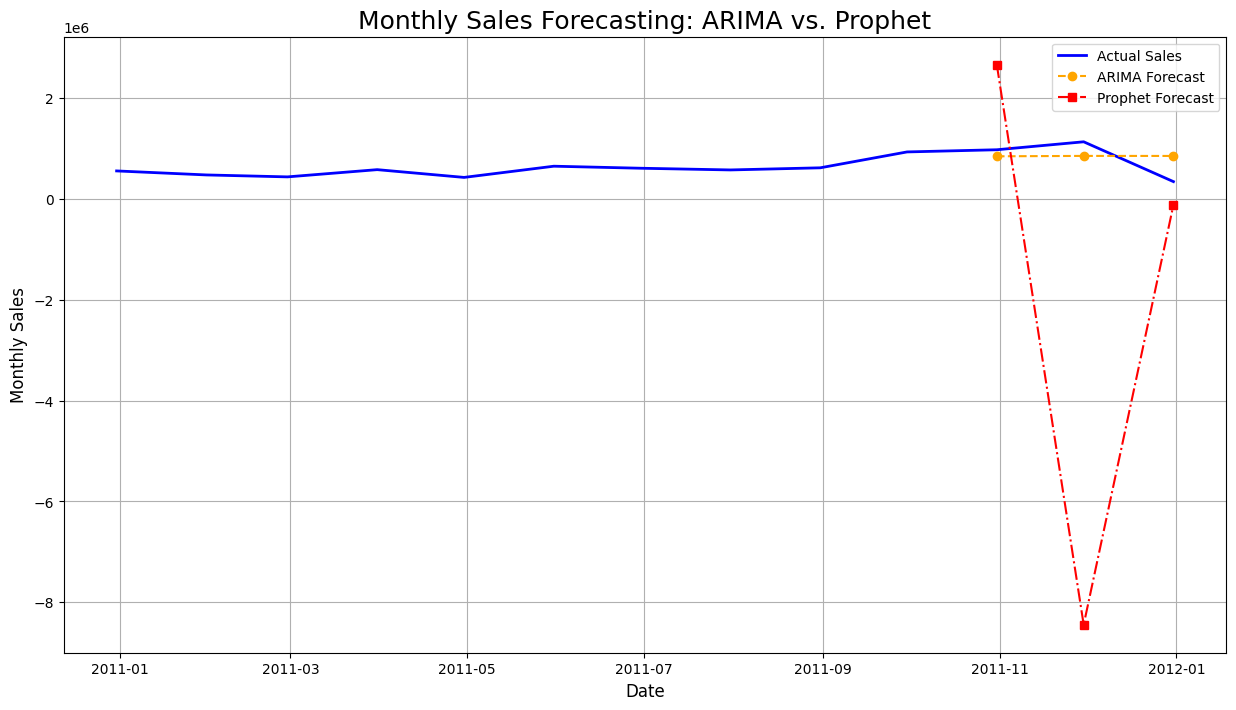

In [9]:
if rmse_prophet < rmse_arima:
    print(f"Prophet performed better with an RMSE of {rmse_prophet:.2f}, an improvement of {((rmse_arima - rmse_prophet) / rmse_arima) * 100:.2f}% over ARIMA.")
    best_model = 'Prophet'
else:
    print(f"ARIMA performed better with an RMSE of {rmse_arima:.2f}, which is an improvement over Prophet's RMSE of {rmse_prophet:.2f}.")
    best_model = 'ARIMA'

# Plotting the results for clear comparison
plt.figure(figsize=(15, 8))
plt.title('Monthly Sales Forecasting: ARIMA vs. Prophet', fontsize=18)

plt.plot(monthly_sales['InvoiceDate'], monthly_sales['TotalSales'], label='Actual Sales', color='blue', linewidth=2)
plt.plot(test_data['InvoiceDate'], arima_forecast_series, label='ARIMA Forecast', color='orange', linestyle='--', marker='o')
plt.plot(prophet_test_data['ds'], prophet_test_forecast, label='Prophet Forecast', color='red', linestyle='-.', marker='s')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Monthly Sales', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [10]:
future_periods = 6 # Forecasting for the next 6 months

if best_model == 'Prophet':
    # Use Prophet's make_future_dataframe for forecasting
    future_dates = model_prophet.make_future_dataframe(periods=future_periods, freq='M')
    forecast = model_prophet.predict(future_dates)
    final_forecast = forecast[['ds', 'yhat']].tail(future_periods)
    print(f"Using the superior Prophet model to forecast the next {future_periods} months:")
    print(final_forecast)
else:
    # Use ARIMA's forecast method
    future_dates = pd.date_range(start=monthly_sales['InvoiceDate'].iloc[-1], periods=future_periods + 1, freq='M')[1:]
    forecast_arima = model_arima_fit.forecast(steps=future_periods)
    final_forecast = pd.DataFrame({
        'ds': future_dates,
        'yhat': forecast_arima.values
    })
    print(f"Using the superior ARIMA model to forecast the next {future_periods} months:")
    print(final_forecast)

Using the superior ARIMA model to forecast the next 6 months:
          ds           yhat
0 2012-01-31  844745.632191
1 2012-02-29  852580.095101
2 2012-03-31  851872.107405
3 2012-04-30  851936.087104
4 2012-05-31  851930.305363
5 2012-06-30  851930.827849
